**Objective of the Starbucks Promotion Predictor Uplift Modeling Task**</br>
In this experiment, we analyze the results of a simulated marketing promotion designed to increase purchases of a product priced at $10.</br>
Each individual in the dataset has:


*   A flag indicating whether they received the promotion (Promotion)
*   A flag indicating whether they eventually purchased the product (purchase)
*   Seven abstract features labeled V1 through V7

The cost to send each promotion is $0.15, so it's crucial to target only those users most likely to be positively influenced by the promotion to avoid wasted spend.

Goal:

Build an uplift model that can determine which individuals should receive the promotion in order to maximize:

*   Incremental Response Rate (IRR): The increase in purchase probability due to the promotion.
*   Net Incremental Revenue (NIR): The extra revenue gained minus the cost of promotion.


In [49]:
!pip install -q scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.3 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm

from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Loading Data**

In [52]:
df_train = pd.read_csv(f'{userdata.get("Starbucks_path")}training.csv')
df_test = pd.read_csv(f'{userdata.get("Starbucks_path")}Test.csv')

print(df_train.shape, df_test.shape)

(84534, 10) (41650, 10)


In [ ]:
df_train.head(5)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [ ]:
df_train.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [ ]:
df_test.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000
mean,63339.155774,0.011525,1.493469,29.986774,-0.000387,1.680792,2.319256,2.505642,1.704010
std,36441.521173,0.106734,0.864138,4.981025,0.999026,0.466175,0.845162,1.119879,0.456492
min,2.000000,0.000000,0.000000,9.202546,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31688.500000,0.000000,1.000000,26.606134,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,63601.000000,0.000000,1.000000,29.979507,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,95017.250000,0.000000,2.000000,33.369989,0.826206,2.000000,3.000000,4.000000,2.000000
max,126178.000000,1.000000,3.000000,55.107509,1.691984,2.000000,4.000000,4.000000,2.000000


### **Exploratory Data Analysis (EDA) Summary**
**Dataset Shape:**

* Training set: *(84534, 10)*
* Test set: *(41650, 10)*

**Feature Types:**

* Categorical: *V1, V4, V5, V6, V7* (values range from 0 to 4)
* Continuous: *V2, V3*

**Treatment Distribution:** </br>
The training dataset is balanced — approximately 50% received the promotion and 50% did not.

**Treatment Effect:**</br>
The purchase rate is higher in the treatment group, suggesting that the promotion is effective overall.

**Purchase Distribution**</br>
Most of the data contains non purchased clients.

**Feature Interaction with Treatment:**</br>
* We plotted purchase rates against feature values, split by the Promotion variable.
* For all features, the treatment group consistently shows higher purchase rates across different values — indicating uplift potential across segments.

**Group Analysis ({Promotion}_{purchase}):**</br>
We split the population into four segments:
* *0_0* : Did not receive promotion and did not purchase
* *0_1* : Did not receive promotion but purchased
* *1_0* : Received promotion but did not purchase
* *1_1* : Received promotion and purchased

Using KDE plots, we looked for "Sure Things" and "Lost Causes":
* **Sure Things**: Feature ranges where *0_1* (red) is higher and similar to 1_1 (green) — people who buy even without promotion.
* **Lost Causes**: Feature ranges where *1_0* (orange) dominates — people who won't buy even with the promotion.

**Correlation Analysis:**</br>
A heatmap of feature correlations showed no strong linear relationships between features.

In [53]:
df_train['Promotion'] = df_train['Promotion'].map({'Yes': 1, 'No': 0})
df_test['Promotion'] = df_test['Promotion'].map({'Yes': 1, 'No': 0})
df_train.groupby('Promotion')['purchase'].agg(['count', 'mean'])

,count,mean
Promotion,,
0,42170,0.007565
1,42364,0.017019


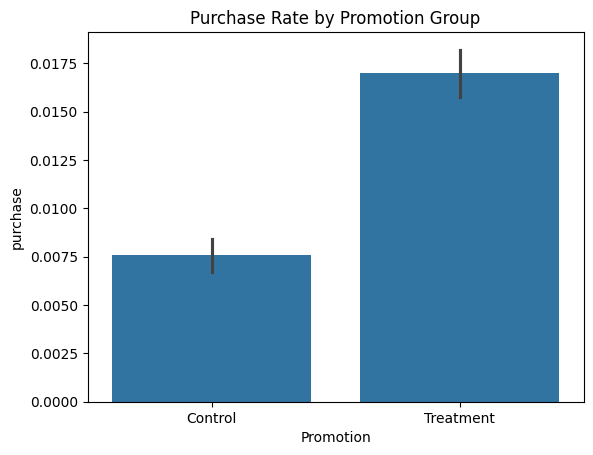

In [ ]:
sns.barplot(x='Promotion', y='purchase', data=df_train)
plt.title("Purchase Rate by Promotion Group")
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.show()

In [ ]:
df_train.groupby('purchase')['purchase'].agg(['count'])

,count
purchase,
0,83494
1,1040


In [ ]:
df_train

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...
84529,126180,No,0,1,30.084876,1.345672,1,1,3,1
84530,126181,Yes,0,3,33.501485,-0.299306,1,1,4,1
84531,126182,No,0,1,31.492019,1.085939,2,3,2,2
84532,126183,No,0,1,37.766106,0.999361,2,2,1,2


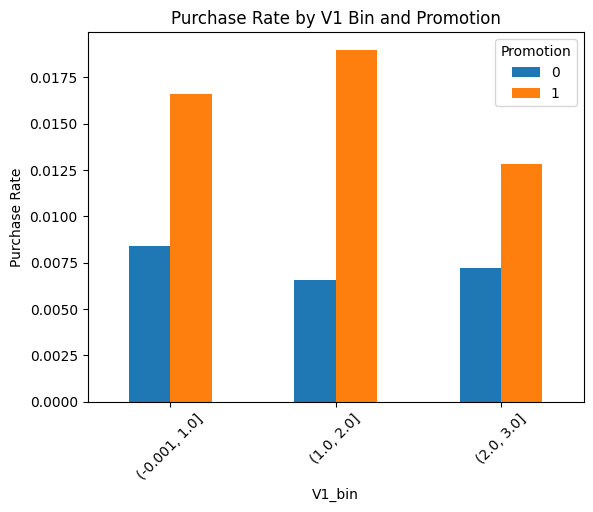

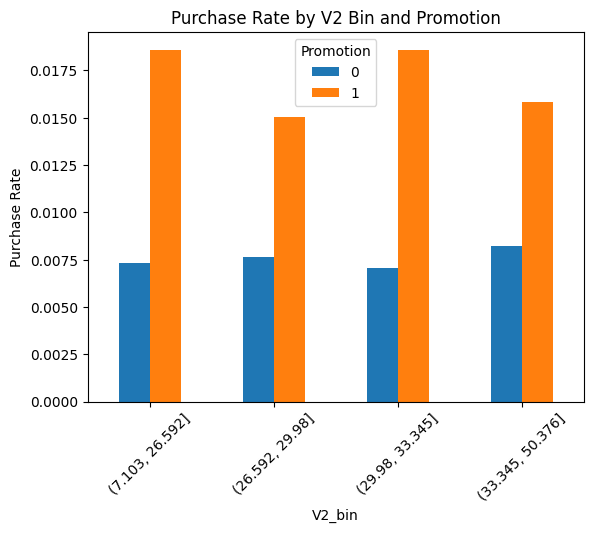

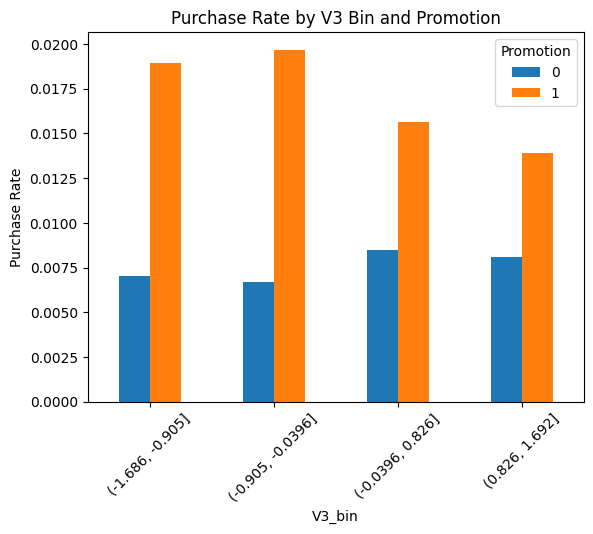

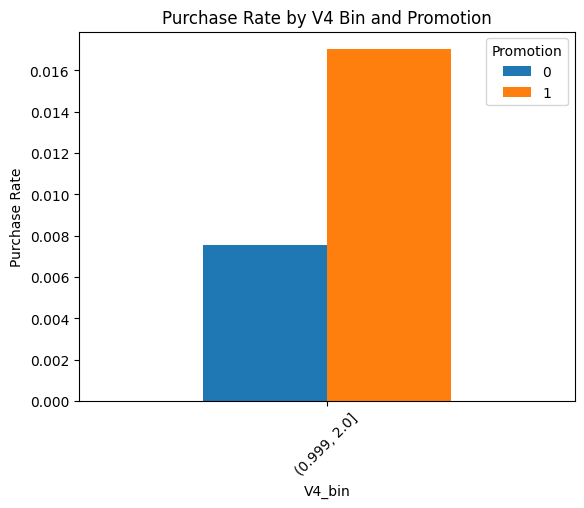

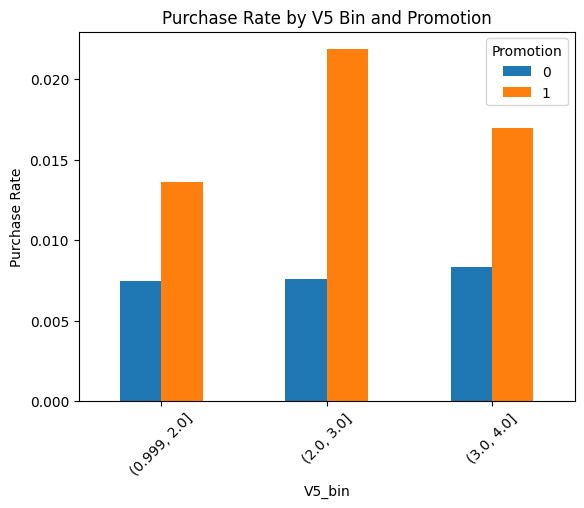

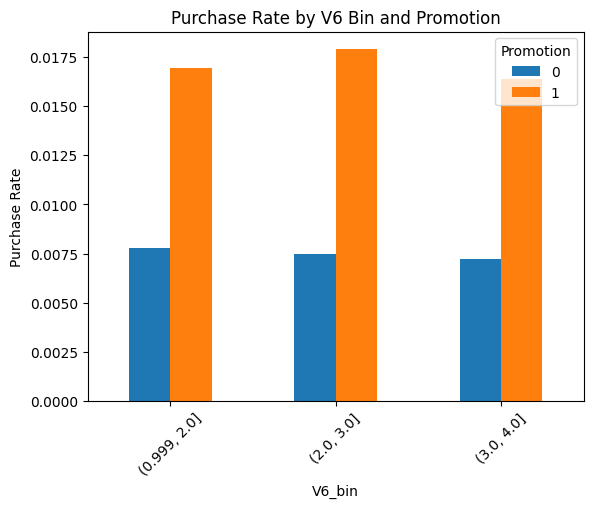

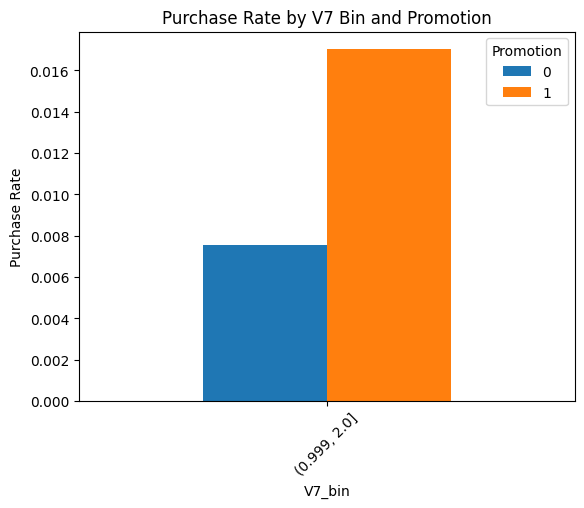

In [ ]:
for i in range(1, 8):
  df_train[f'V{i}_bin'] = pd.qcut(df_train[f'V{i}'], q=4, duplicates='drop')

  purchase_by_bin = df_train.groupby([f'V{i}_bin', 'Promotion'], observed=True)['purchase'].mean().unstack()
  purchase_by_bin.plot(kind='bar')
  plt.title(f"Purchase Rate by V{i} Bin and Promotion")
  plt.ylabel("Purchase Rate")
  plt.xticks(rotation=45)
  plt.show()

In [ ]:
df_train.groupby('Group')['Promotion'].agg('count')

,Promotion
Group,
0_0,41851
0_1,319
1_0,41643
1_1,721


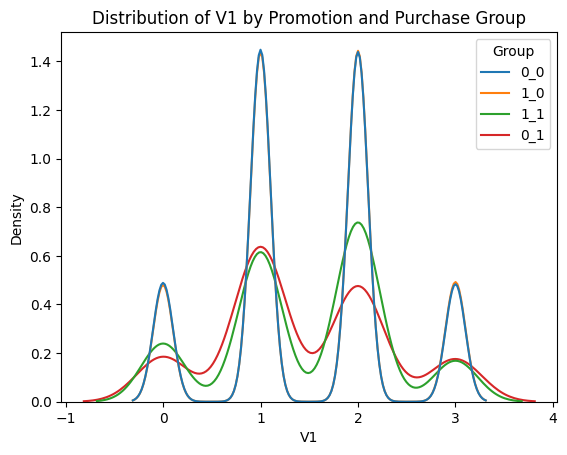

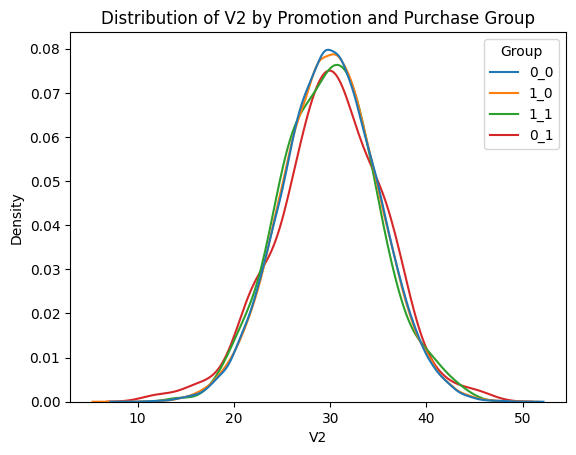

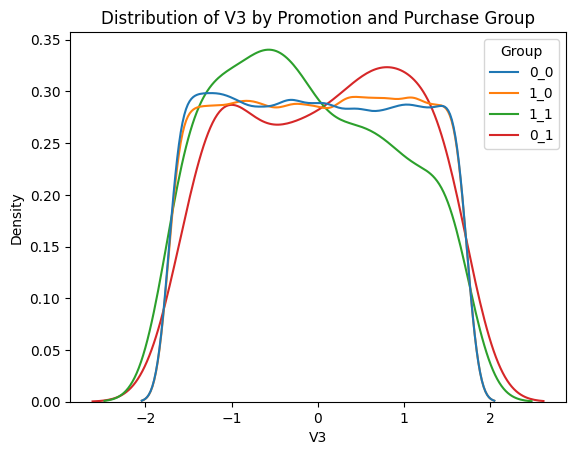

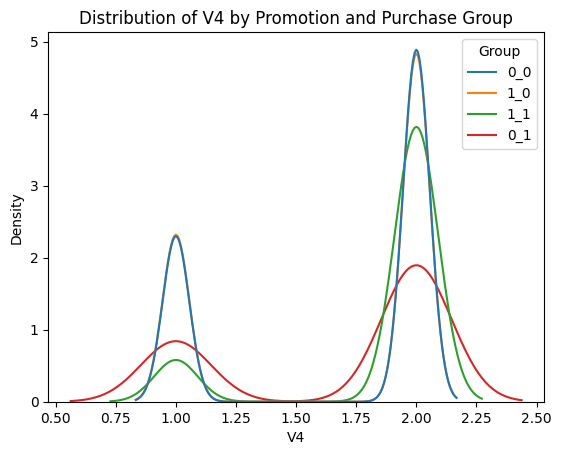

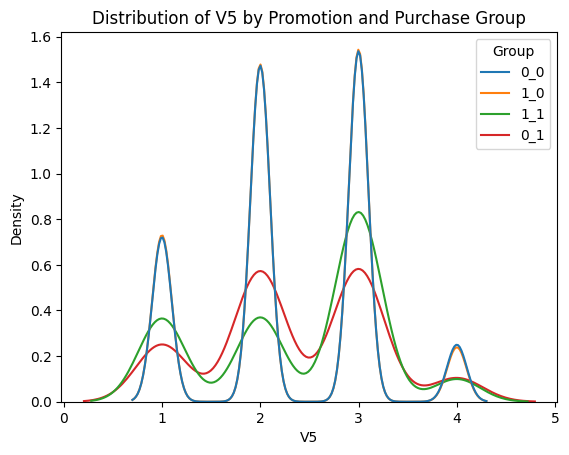

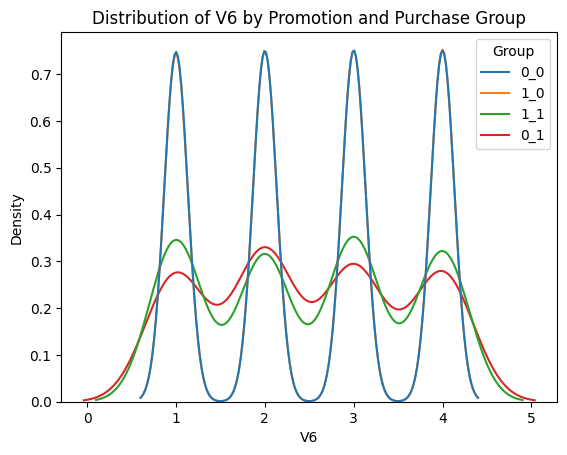

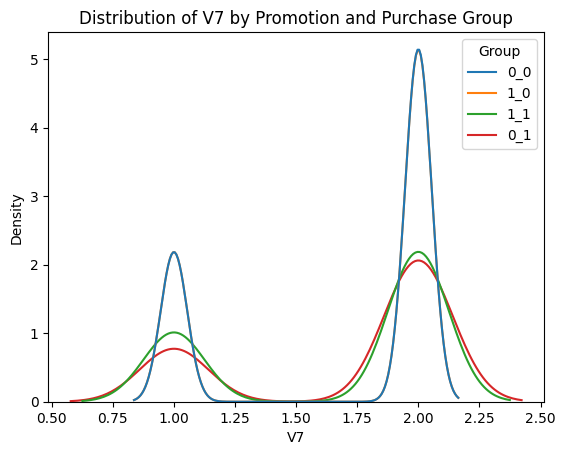

In [ ]:
df_train['Group'] = df_train['Promotion'].astype(str) + '_' + df_train['purchase'].astype(str)
for i in range(1, 8):
    plt.figure()
    sns.kdeplot(data=df_train, x=f'V{i}', hue='Group', common_norm=False)
    plt.title(f'Distribution of V{i} by Promotion and Purchase Group')
    plt.show()

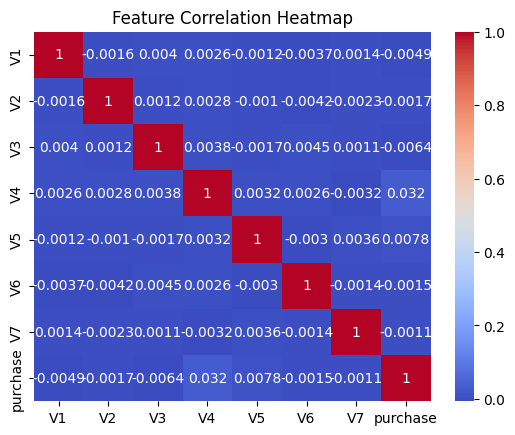

In [ ]:
corr = df_train[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'purchase']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

### **Train and Results**
To evaluate our models, we implemented two key utility functions:
* *calculate_uplift_metrics* : Divides predictions into quantile buckets and computes uplift or Net Incremental Revenue (NIR) metrics per bucket.
* *plot_uplift_curve* : Visualizes model performance using either Qini or NIR curves, and optionally returns the Qini coefficient for comparison.

We experimented with several uplift modeling strategies:
* Two-Model Approach (T-Learner) using a Random Forest Classifier as the base model.
* Switched to XGBoost Classifier, which improved performance.
* Incorporated the sklift package with the TwoModels method and set method='ddr_treatment' to correct for treatment/control imbalance.
*Finally, used the Single-Model approach (S-Learner) with XGBoost to directly predict uplift scores.

With each iteration, model performance improved. Our final model achieved:
* Qini Coefficient: 50.22 (starting from 18.03)
* Net Incremental Revenue (NIR): ~40 (starting from around 2)

These results indicate a significant uplift and profitable targeting strategy.

In [79]:
def calculate_uplift_metrics(results_df, uplift_column, metric_type="uplift", avg_rev_per_purchase=10, cost_per_promo=0.15, n_buckets=10):
    """
    Calculates cumulative uplift metrics for either standard uplift or Net Incremental Revenue (NIR).

    Args:
        results_df (pd.DataFrame): DataFrame containing uplift score, 'purchase', and 'Promotion' columns
        uplift_column (str): Name of the column containing uplift scores
        metric_type (str): Either "uplift" for standard uplift metrics or "nir" for Net Incremental Revenue
        avg_rev_per_purchase (float): Average revenue per purchase (used only for NIR calculations)
        cost_per_promo (float): Cost per promotion/treatment (used only for NIR calculations)
        n_buckets (int): Number of quantiles/deciles to divide the data into

    Returns:
        pd.DataFrame: DataFrame with cumulative metrics per bucket
    """

    # Sort by uplift score in descending order
    df_sorted = results_df.sort_values(by=uplift_column, ascending=False).reset_index(drop=True)

    # Assign each row to a bucket using quantiles
    df_sorted['bucket'] = pd.qcut(df_sorted[uplift_column], q=n_buckets, labels=False, duplicates='drop')

    # Aggregate performance per bucket
    bucket_performance = df_sorted.groupby('bucket').apply(lambda x: pd.Series({
        'total_users': len(x),
        'treated_users': (x['Promotion'] == 1).sum(),
        'control_users': (x['Promotion'] == 0).sum(),
        'treated_purchases': (x['purchase'][x['Promotion'] == 1]).sum(),
        'control_purchases': (x['purchase'][x['Promotion'] == 0]).sum()
    }), include_groups=False).reset_index()

    # Handle NaN values that might arise from 0 users in a group
    bucket_performance = bucket_performance.fillna(0)

    # Calculate response rates and incremental metrics per bucket
    bucket_performance['treated_response_rate'] = (
        bucket_performance['treated_purchases'] / bucket_performance['treated_users']
    ).fillna(0)

    bucket_performance['control_response_rate'] = (
        bucket_performance['control_purchases'] / bucket_performance['control_users']
    ).fillna(0)

    bucket_performance['incremental_response_rate'] = (
        bucket_performance['treated_response_rate'] - bucket_performance['control_response_rate']
    )

    # Calculate incremental purchases per bucket
    bucket_performance['incremental_purchases'] = (
        bucket_performance['treated_purchases'] - bucket_performance['control_purchases']
    )

    # Calculate cumulative basic metrics (common to both types)
    bucket_performance['cumulative_users'] = bucket_performance['total_users'].cumsum()
    bucket_performance['percentage_of_population'] = (
        (bucket_performance['cumulative_users'] / bucket_performance['total_users'].sum()) * 100
    )

    bucket_performance['cumulative_treated_purchases'] = bucket_performance['treated_purchases'].cumsum()
    bucket_performance['cumulative_control_purchases'] = bucket_performance['control_purchases'].cumsum()

    # Calculate metric-specific columns
    if metric_type == "nir":
        # NIR-specific calculations
        bucket_performance['incremental_revenue'] = (
            bucket_performance['incremental_purchases'] * avg_rev_per_purchase
        )

        bucket_performance['promotion_cost'] = (
            bucket_performance['treated_users'] * cost_per_promo
        )

        bucket_performance['net_incremental_revenue'] = (
            bucket_performance['incremental_revenue'] - bucket_performance['promotion_cost']
        )

        # Cumulative NIR metrics
        bucket_performance['cumulative_net_incremental_revenue'] = (
            bucket_performance['net_incremental_revenue'].cumsum()
        )

        bucket_performance['cumulative_incremental_revenue'] = (
            bucket_performance['incremental_revenue'].cumsum()
        )

        bucket_performance['cumulative_promotion_cost'] = (
            bucket_performance['promotion_cost'].cumsum()
        )

    else:
        # Standard uplift calculations
        bucket_performance['cumulative_uplift'] = (
            bucket_performance['cumulative_treated_purchases'] -
            bucket_performance['cumulative_control_purchases']
        )

        # Alternative calculation for cumulative uplift (same result, different approach)
        bucket_performance['cumulative_incremental_purchases'] = (
            bucket_performance['incremental_purchases'].cumsum()
        )

    return bucket_performance

def plot_uplift_curve(df, curve_type="qini", avg_revenue_per_purchase=10, cost_per_promo=0.15, title=None, baseline_noise=0.05, return_qini_coef=False, labels=None):
    """
    Plots either a Qini curve (incremental responses) or Net Incremental Revenue (NIR) curve.
    Can handle single DataFrame or list of DataFrames.

    Args:
        df (pd.DataFrame or list): Single DataFrame or list of DataFrames with columns
                                  [treated_users, control_users, treated_purchases, control_purchases]
        curve_type (str): Either "qini" for Qini curve or "nir" for Net Incremental Revenue curve
        avg_revenue_per_purchase (float): Average revenue per purchase (used only for NIR curve)
        cost_per_promo (float): Cost per promotion/treatment (used only for NIR curve)
        title (str): Title for the plot. If None, auto-generates based on curve_type
        baseline_noise (float): Standard deviation for random baseline noise
        return_qini_coef (bool): If True, also returns the Qini coefficient(s)
        labels (list): List of labels for each DataFrame. If None, auto-generates labels

    Returns:
        None: Displays the plot, or float/list if return_qini_coeff=True
    """

    # Convert single DataFrame to list for uniform processing
    if isinstance(df, pd.DataFrame):
        df_list = [df]
        single_df = True
    else:
        df_list = df
        single_df = False

    # Generate default labels if not provided
    if labels is None:
        if single_df:
            labels = ['Model']
        else:
            labels = [f'Model {i+1}' for i in range(len(df_list))]
    elif len(labels) != len(df_list):
        raise ValueError(f"Number of labels ({len(labels)}) must match number of DataFrames ({len(df_list)})")

    # Set default title if not provided
    if title is None:
        title = "Net Incremental Revenue Curve" if curve_type == "nir" else "Uplift Curve (Qini Curve)"

    # Define colors for multiple curves
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    qini_coefficients = []
    baseline_plotted = False

    for idx, (current_df, label) in enumerate(zip(df_list, labels)):
        color = colors[idx % len(colors)]

        # Extract data from DataFrame
        treated_users = current_df.loc[:, 'treated_users'].values
        control_users = current_df.loc[:, 'control_users'].values
        treated_purchases = current_df.loc[:, 'treated_purchases'].values
        control_purchases = current_df.loc[:, 'control_purchases'].values

        # Calculate conversion rates (handle division by zero)
        treated_conv_rate = np.divide(treated_purchases, treated_users,
                                     out=np.zeros_like(treated_purchases, dtype=float),
                                     where=treated_users!=0)
        control_conv_rate = np.divide(control_purchases, control_users,
                                     out=np.zeros_like(control_purchases, dtype=float),
                                     where=control_users!=0)

        # Calculate uplift score (difference in conversion rates)
        uplift_score = treated_conv_rate - control_conv_rate

        # Create DataFrame for sorting by uplift score
        df_with_uplift = pd.DataFrame({
            'treated_users': treated_users,
            'control_users': control_users,
            'treated_purchases': treated_purchases,
            'control_purchases': control_purchases,
            'uplift_score': uplift_score
        })

        # Sort by uplift score (descending - highest uplift first)
        df_sorted = df_with_uplift.sort_values('uplift_score', ascending=False).reset_index(drop=True)

        # Calculate incremental responses for each segment
        control_rate_for_treated = np.divide(df_sorted['control_purchases'], df_sorted['control_users'],
                                            out=np.zeros_like(df_sorted['control_purchases'], dtype=float),
                                            where=df_sorted['control_users']!=0)

        incremental_responses = (df_sorted['treated_purchases'] - (df_sorted['treated_users'] * control_rate_for_treated))

        # Calculate net responses based on curve type
        if curve_type == "nir":
            # For NIR curve: subtract costs in response units
            cost_in_responses = (df_sorted['treated_users'] * cost_per_promo) / avg_revenue_per_purchase
            net_responses = incremental_responses - cost_in_responses
            y_label = 'Cumulative Net Incremental Responses'
        else:
            # For Qini curve: use raw incremental responses
            net_responses = incremental_responses
            y_label = 'Cumulative Incremental Responses'

        # Calculate cumulative metrics
        cumulative_treated_users = df_sorted['treated_users'].cumsum()
        cumulative_responses = net_responses.cumsum()

        # Calculate percentage of population targeted
        total_population = df_sorted['treated_users'].sum()
        pct_population_targeted = (cumulative_treated_users / total_population) * 100

        # For Qini curve only: prepend 0 values to start at origin (0,0)
        if curve_type == "qini":
            pct_population_targeted = pd.concat([pd.Series([0]), pct_population_targeted]).reset_index(drop=True)
            cumulative_responses = pd.concat([pd.Series([0]), cumulative_responses]).reset_index(drop=True)

            # Generate baseline for each DataFrame
        n_points = len(pct_population_targeted)

        # Handle edge case where there are no data points
        if n_points == 0 or (curve_type == "qini" and n_points <= 1):
            raise ValueError("No valid data points found in the dataset")

        if curve_type == "nir":
            # NIR baseline: realistic baseline that starts at 0 and grows based on average performance
            avg_net_response_rate = cumulative_responses.iloc[-1] / total_population if total_population > 0 else 0
            baseline = pct_population_targeted * avg_net_response_rate * (total_population / 100)
            baseline_noise_factor = baseline_noise
        else:
            # Qini baseline: linear baseline representing random targeting
            final_responses = cumulative_responses.iloc[-1]
            baseline = (pct_population_targeted / 100) * final_responses
            baseline_noise_factor = baseline_noise * 0.1  # Reduced noise for Qini to keep it mostly linear

        # Add random variation to baseline
        if baseline_noise > 0:
            baseline_std = np.std(cumulative_responses) if len(cumulative_responses) > 1 else 1.0
            baseline_noise_values = np.random.normal(0, baseline_noise_factor * baseline_std, n_points)
            baseline = baseline + baseline_noise_values

            # Ensure baseline starts at 0 for Qini curve
            if curve_type == "qini":
                baseline[0] = 0

        # Convert to numpy arrays for consistent plotting
        baseline_vals = np.array(baseline)

        # Plot baseline (only once for visual clarity)
        if not baseline_plotted:
            ax1.plot(pct_population_targeted, baseline_vals, 'r--', linewidth=2,
                    label='Random Targeting Baseline', alpha=0.7)
            baseline_plotted = True

        # Convert to numpy arrays for consistent plotting
        x_vals = np.array(pct_population_targeted)
        y_vals = np.array(cumulative_responses)

        # Calculate Qini coefficient if needed
        qini_coefficient = 0
        curve_label = label
        if curve_type == "qini":
            qini_coefficient = np.trapezoid(y_vals - baseline_vals, x_vals / 100)
            qini_coefficients.append(qini_coefficient)
            curve_label += f' (Qini: {qini_coefficient:.2f})'

        # Plot primary curve (responses)
        ax1.plot(x_vals, y_vals, color=color, linewidth=2.5, marker='o', markersize=4,
                label=curve_label, alpha=0.8)

        # Add fill areas for each curve
        uplift_better = y_vals > baseline_vals
        uplift_worse = y_vals <= baseline_vals

        # Use lighter alpha for multiple curves and only add labels for the first curve
        fill_alpha = 0.08 if len(df_list) > 1 else 0.15

        if idx == 0:
            ax1.fill_between(x_vals, y_vals, baseline_vals, alpha=fill_alpha, color='green',
                           where=uplift_better, interpolate=True, label='Uplift > Random')
            ax1.fill_between(x_vals, y_vals, baseline_vals, alpha=fill_alpha, color='red',
                           where=uplift_worse, interpolate=True, label='Uplift ≤ Random')
        else:
            ax1.fill_between(x_vals, y_vals, baseline_vals, alpha=fill_alpha, color='green',
                           where=uplift_better, interpolate=True)
            ax1.fill_between(x_vals, y_vals, baseline_vals, alpha=fill_alpha, color='red',
                           where=uplift_worse, interpolate=True)

    # Add horizontal line at y=0
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)

    # Set labels and formatting
    ax1.set_xlabel('Percentage of Population Targeted (Ordered by Uplift Score)', fontsize=12)
    ax1.set_ylabel(y_label, fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_xlim(0, 100)
    ax1.grid(True, alpha=0.3)

    # Add secondary axis only for NIR
    if curve_type == "nir":
        ax2 = ax1.twinx()
        ax2.set_ylabel('Cumulative Net Incremental Revenue ($)', fontsize=12)

        # Plot revenue curves for each model
        for idx, (current_df, label) in enumerate(zip(df_list, labels)):
            color = colors[idx % len(colors)]
            # Recalculate y_vals for this specific dataframe (simplified version)
            treated_users = current_df.loc[:, 'treated_users'].values
            control_users = current_df.loc[:, 'control_users'].values
            treated_purchases = current_df.loc[:, 'treated_purchases'].values
            control_purchases = current_df.loc[:, 'control_purchases'].values

            treated_conv_rate = np.divide(treated_purchases, treated_users,
                                         out=np.zeros_like(treated_purchases, dtype=float),
                                         where=treated_users!=0)
            control_conv_rate = np.divide(control_purchases, control_users,
                                         out=np.zeros_like(control_purchases, dtype=float),
                                         where=control_users!=0)
            uplift_score = treated_conv_rate - control_conv_rate

            df_with_uplift = pd.DataFrame({
                'treated_users': treated_users,
                'control_users': control_users,
                'treated_purchases': treated_purchases,
                'control_purchases': control_purchases,
                'uplift_score': uplift_score
            })
            df_sorted = df_with_uplift.sort_values('uplift_score', ascending=False).reset_index(drop=True)

            control_rate_for_treated = np.divide(df_sorted['control_purchases'], df_sorted['control_users'],
                                                out=np.zeros_like(df_sorted['control_purchases'], dtype=float),
                                                where=df_sorted['control_users']!=0)
            incremental_responses = (df_sorted['treated_purchases'] - (df_sorted['treated_users'] * control_rate_for_treated))
            cost_in_responses = (df_sorted['treated_users'] * cost_per_promo) / avg_revenue_per_purchase
            net_responses = incremental_responses - cost_in_responses
            cumulative_responses = net_responses.cumsum()

            cumulative_treated_users = df_sorted['treated_users'].cumsum()
            total_population = df_sorted['treated_users'].sum()
            pct_population_targeted = (cumulative_treated_users / total_population) * 100

            ax2.plot(pct_population_targeted, cumulative_responses * avg_revenue_per_purchase,
                    color=color, linestyle='--', linewidth=2, alpha=0.6)

        ax2.tick_params(axis='y')

    # Reorder legend to put model curves first, then baseline, then fill areas
    lines_1, labels_1 = ax1.get_legend_handles_labels()

    # Separate different types of legend entries
    model_lines = []
    model_labels = []
    baseline_lines = []
    baseline_labels = []
    fill_lines = []
    fill_labels = []

    for line, label in zip(lines_1, labels_1):
        if 'Random Targeting Baseline' in label:
            baseline_lines.append(line)
            baseline_labels.append(label)
        elif 'Uplift >' in label or 'Uplift ≤' in label:
            fill_lines.append(line)
            fill_labels.append(label)
        else:
            model_lines.append(line)
            model_labels.append(label)

    # Combine in desired order: models first, then baseline, then fill areas
    ordered_lines = model_lines + baseline_lines + fill_lines
    ordered_labels = model_labels + baseline_labels + fill_labels

    if curve_type == "nir":
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        # Add revenue lines but don't include them in legend to avoid clutter
        ax1.legend(ordered_lines, ordered_labels, loc='best', fontsize=9)
    else:
        ax1.legend(ordered_lines, ordered_labels, loc='best', fontsize=9)

    plt.title(title, fontsize=16, fontweight='bold')
    fig.tight_layout()
    plt.show()

    # Return Qini coefficients if requested
    if return_qini_coef and curve_type == "qini":
        if single_df:
            return qini_coefficients[0]
        else:
            return qini_coefficients

In [60]:
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

df_treatment = df_train[df_train['Promotion'] == 1]
df_control = df_train[df_train['Promotion'] == 0]

lst_uplift_irr = []
lst_uplift_nir = []

#### **T-Learner: Random Forest**

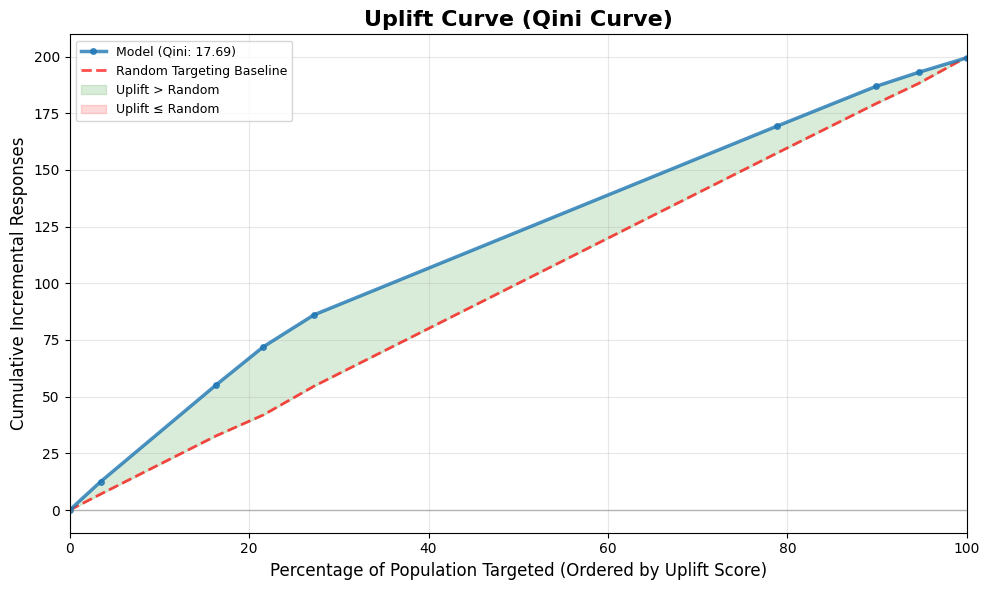

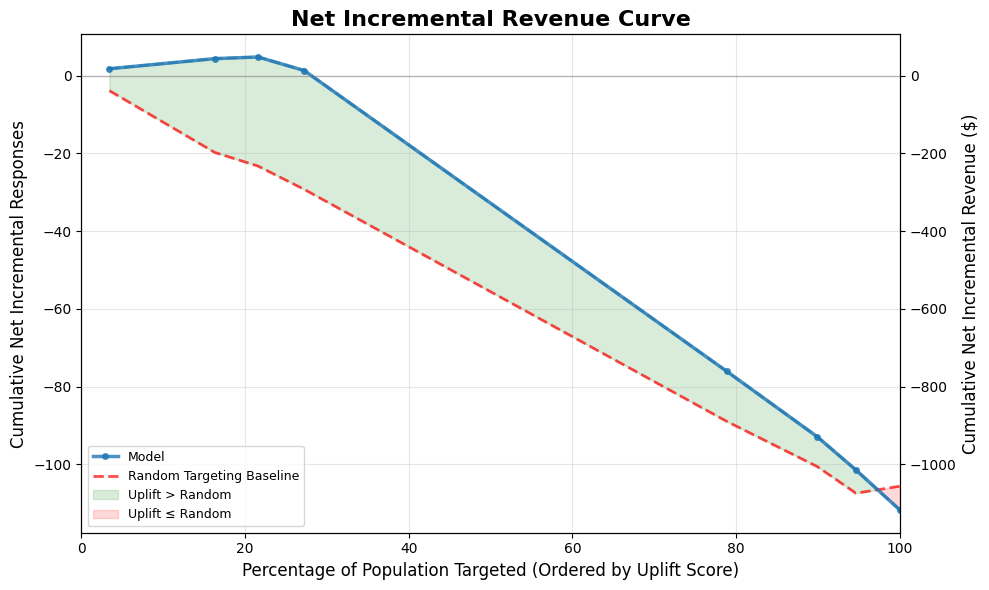

In [80]:
from sklearn.ensemble import RandomForestClassifier

model_treat = RandomForestClassifier(class_weight='balanced', random_state=999)
model_treat.fit(df_treatment[cols], df_treatment['purchase'])

model_control = RandomForestClassifier(class_weight='balanced', random_state=999)
model_control.fit(df_control[cols], df_control['purchase'])

# Predict uplift on validation
prob_treat = model_treat.predict_proba(df_test[cols])[:, 1]
prob_control = model_control.predict_proba(df_test[cols])[:, 1]

df_test['uplift_RF'] = prob_treat - prob_control

lst_uplift_irr.append(calculate_uplift_metrics(df_test, 'uplift_RF', "uplift", n_buckets=20))
plot_uplift_curve(lst_uplift_irr[-1], curve_type="qini")

lst_uplift_nir.append(calculate_uplift_metrics(df_test, 'uplift_RF', "nir", n_buckets=20))
plot_uplift_curve(lst_uplift_nir[-1], curve_type="nir")

#### **T-Learner: XGBoost**

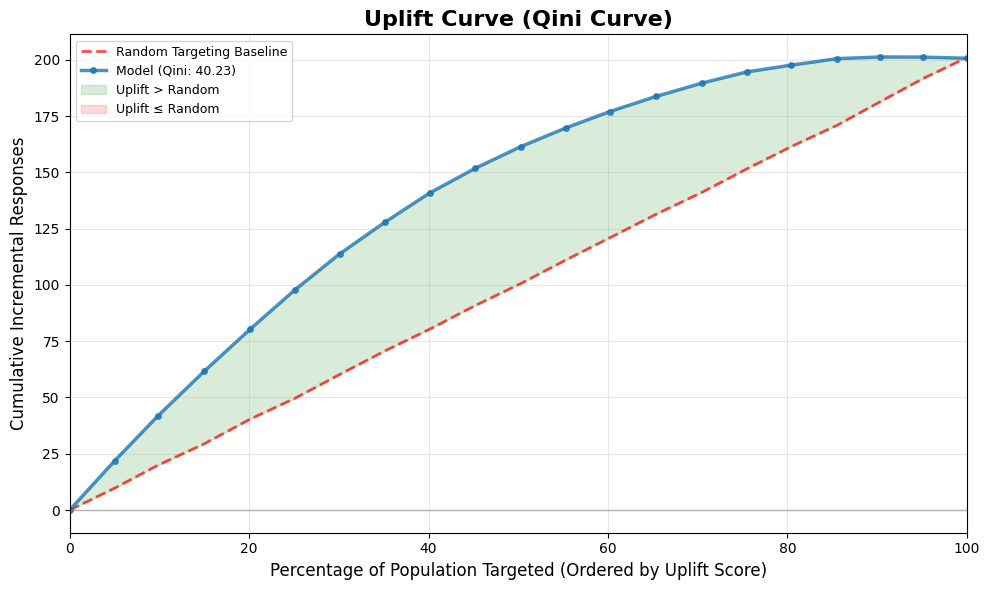

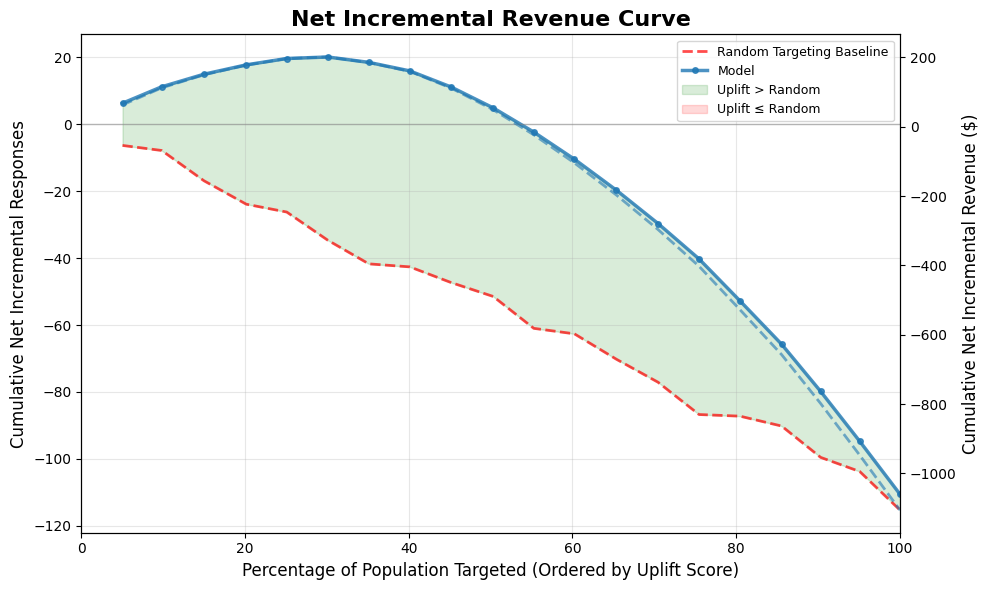

In [62]:
from xgboost import XGBClassifier

# For imbalance data
train_buyers = df_treatment['purchase'].sum() + df_control['purchase'].sum()
train_not_buyers = len(df_treatment) + len(df_control) - train_buyers
scale_pos_weight = int(train_not_buyers / train_buyers) * 1.5

model_treat = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=999)
model_treat.fit(df_treatment[cols], df_treatment['purchase'])

model_control = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=999)
model_control.fit(df_control[cols], df_control['purchase'])

# Predict uplift on validation
prob_treat = model_treat.predict_proba(df_test[cols])[:, 1]
prob_control = model_control.predict_proba(df_test[cols])[:, 1]

df_test['uplift_XGB'] = prob_treat - prob_control

lst_uplift_irr.append(calculate_uplift_metrics(df_test, 'uplift_XGB', "uplift", n_buckets=20))
plot_uplift_curve(lst_uplift_irr[-1], curve_type="qini")

lst_uplift_nir.append(calculate_uplift_metrics(df_test, 'uplift_XGB', "nir", n_buckets=20))
plot_uplift_curve(lst_uplift_nir[-1], curve_type="nir")

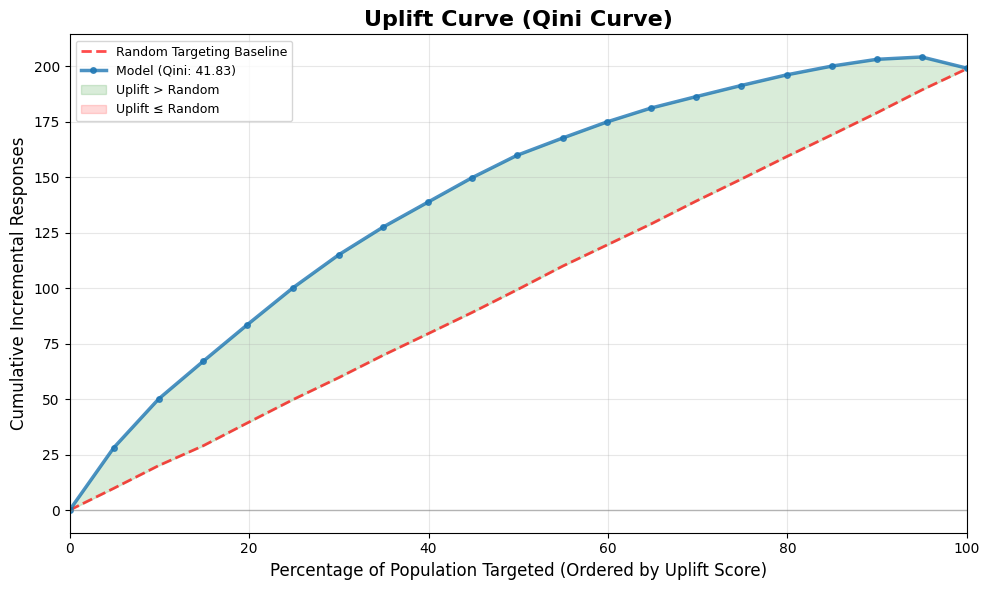

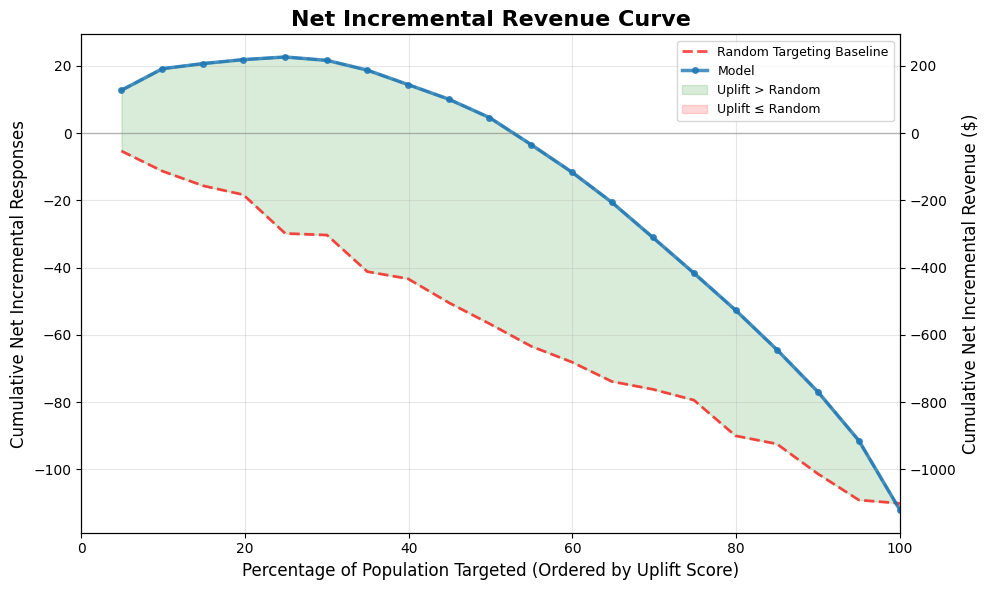

In [63]:
from sklift.models import TwoModels

uplift_model = TwoModels(
    estimator_trmnt=XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=999),
    estimator_ctrl=XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=999),
    method='ddr_treatment'
)
uplift_model.fit(df_train[cols], df_train['purchase'], treatment=df_train['Promotion'])
df_test['uplift_TwoModels'] = uplift_model.predict(df_test[cols])

lst_uplift_irr.append(calculate_uplift_metrics(df_test, 'uplift_TwoModels', "uplift", n_buckets=20))
plot_uplift_curve(lst_uplift_irr[-1], curve_type="qini")

lst_uplift_nir.append(calculate_uplift_metrics(df_test, 'uplift_TwoModels', "nir", n_buckets=20))
plot_uplift_curve(lst_uplift_nir[-1], curve_type="nir")

#### **S-Learner: XGBoost**

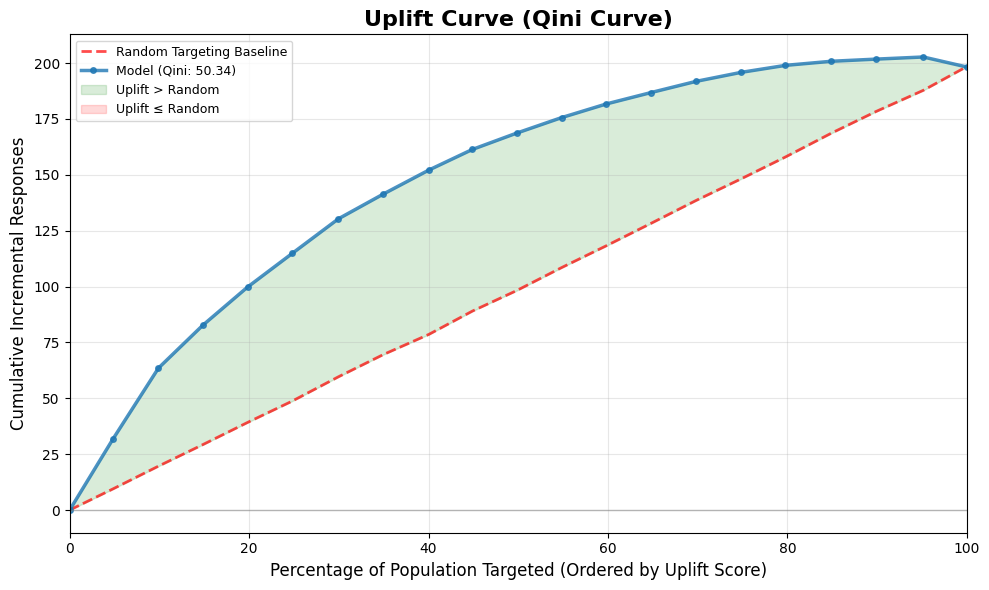

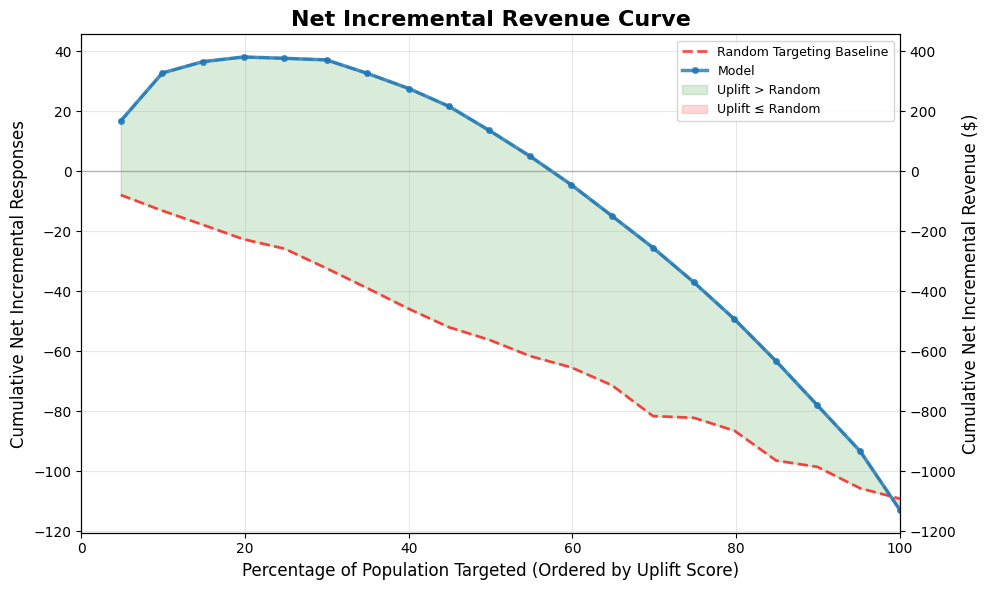

In [75]:
from sklift.models import SoloModel

uplift_model = SoloModel(XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=999))
uplift_model.fit(df_train[cols], df_train['purchase'], treatment=df_train['Promotion'])
df_test['uplift_SoloModel'] = uplift_model.predict(df_test[cols])

lst_uplift_irr.append(calculate_uplift_metrics(df_test, 'uplift_SoloModel', "uplift", n_buckets=20))
plot_uplift_curve(lst_uplift_irr[-1], curve_type="qini")

lst_uplift_nir.append(calculate_uplift_metrics(df_test, 'uplift_SoloModel', "nir", n_buckets=20))
plot_uplift_curve(lst_uplift_nir[-1], curve_type="nir")

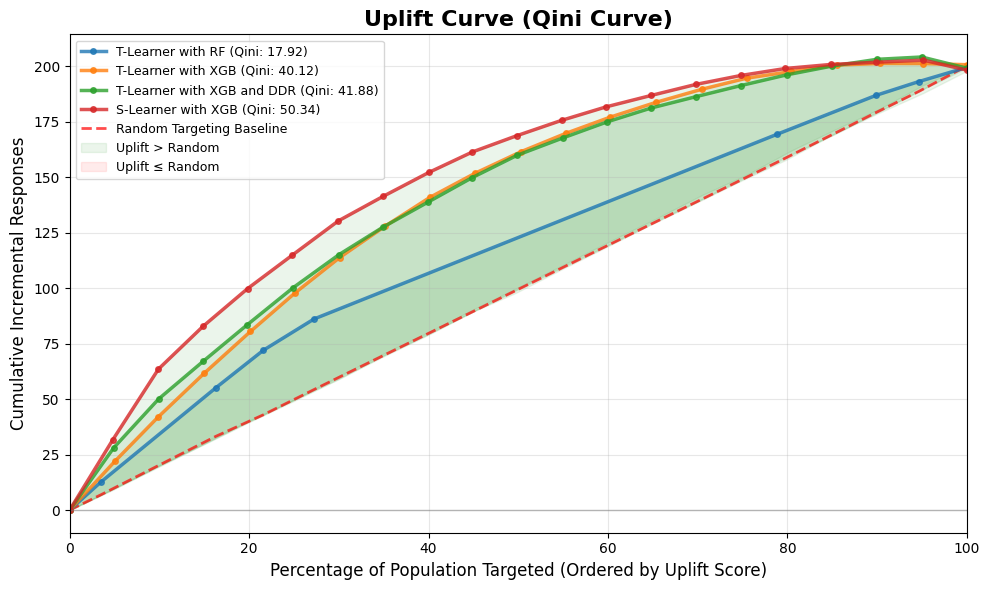

In [83]:
plot_uplift_curve(lst_uplift_irr, curve_type="qini", labels=["T-Learner with RF", "T-Learner with XGB", "T-Learner with XGB and DDR", "S-Learner with XGB"])

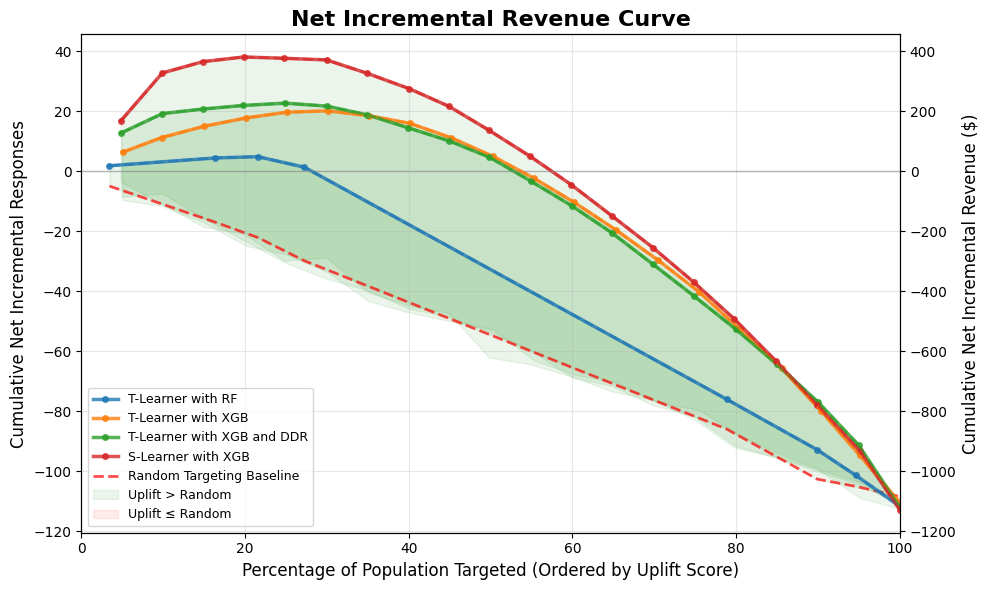

In [84]:
plot_uplift_curve(lst_uplift_irr, curve_type="nir", labels=["T-Learner with RF", "T-Learner with XGB", "T-Learner with XGB and DDR", "S-Learner with XGB"])